In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [100]:
train = pd.read_csv('../data/cleaned/cleaned_train.csv')
test = pd.read_csv('../data/cleaned/cleaned_test.csv')
unseen = pd.read_csv('../data/cleaned/cleaned_unseen.csv')

In [101]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S,Mr
1,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S,Mr
2,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S,Mr
3,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S,Mr
4,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,Miss


# New Features

In [102]:
def new_features(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['IsAlone'] = 1 
    df['IsAlone'].loc[df['FamilySize'] > 1] = 0 

    df['HasCabin'] = 0
    df['HasCabin'].loc[df['Cabin'].notnull()] = 1
    
    return df

In [103]:
train = new_features(train)
test = new_features(test)
unseen = new_features(unseen)

C:\Users\66959\AppData\Local\Temp\ipykernel_18224\1822779959.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['IsAlone'].loc[df['FamilySize'] > 1] = 0
C:\Users\66959\AppData\Local\Temp\ipykernel_18224\1822779959.py:5: SettingWithCopyWa

In [104]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,HasCabin
0,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S,Mr,1,1,1
1,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S,Mr,1,1,0
2,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S,Mr,1,1,0
3,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S,Mr,2,0,0
4,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,Miss,7,0,0


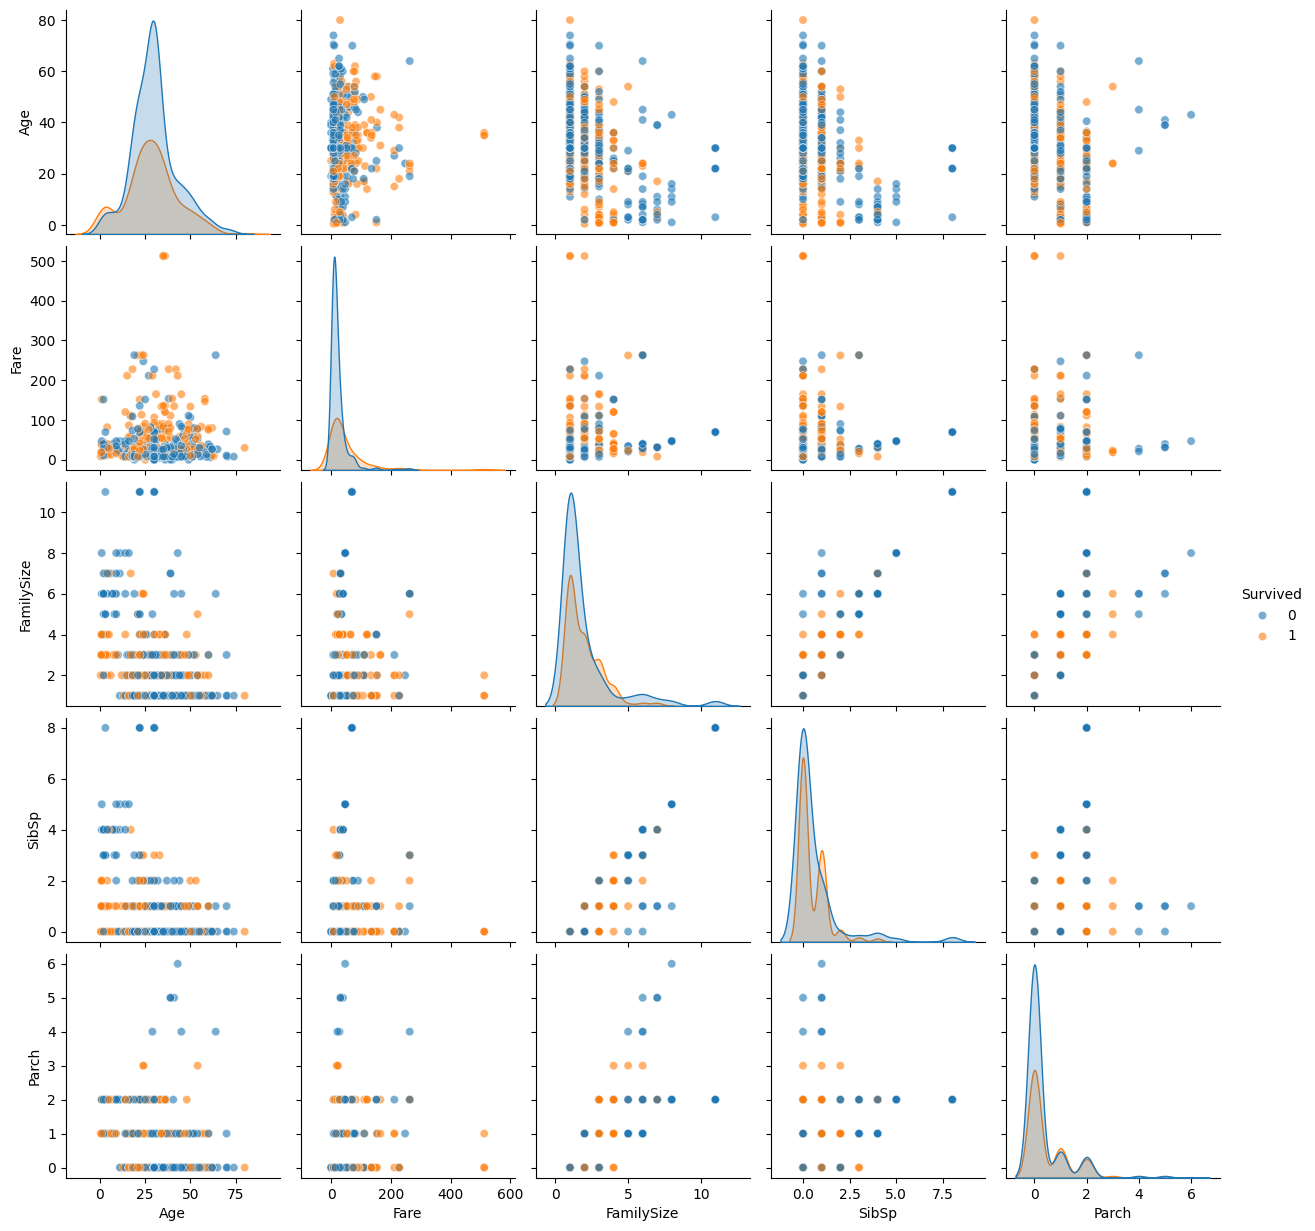

In [105]:
num_cols = ['Survived', 'Age', 'Fare', 'FamilySize', 'SibSp', 'Parch']

sns.pairplot(
    train[num_cols],
    hue='Survived',
    diag_kind='kde',
    plot_kws={'alpha': 0.6}
)

plt.show()

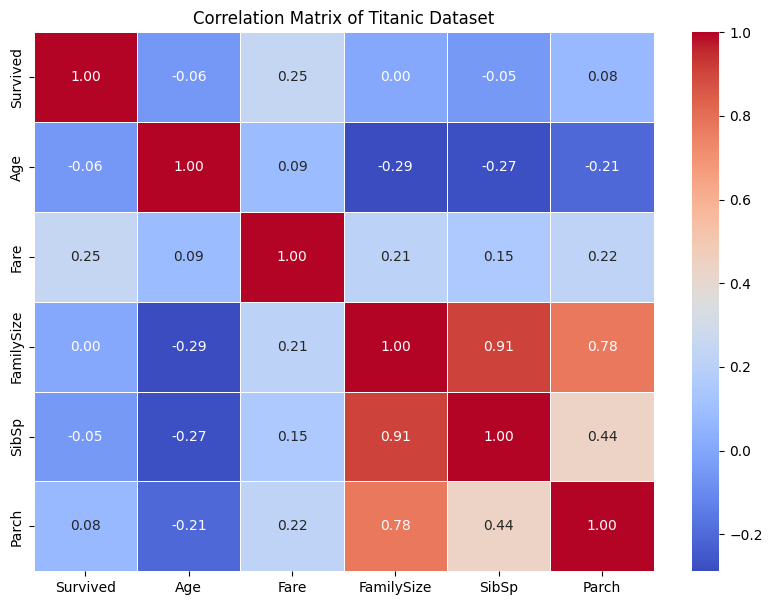

In [106]:
corr = train[num_cols].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Titanic Dataset")
plt.show()

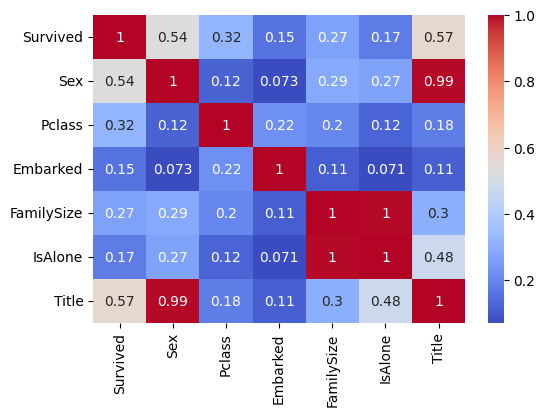

In [107]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

cat_cols = ['Survived', 'Sex', 'Pclass', 'Embarked', 'FamilySize', 'IsAlone', 'Title']
cramers_matrix = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), 
                              index=cat_cols, columns=cat_cols)

for i in cat_cols:
    for j in cat_cols:
        cramers_matrix.loc[i, j] = cramers_v(train[i], train[j])

plt.figure(figsize=(6,4))
sns.heatmap(cramers_matrix, annot=True, cmap='coolwarm')
plt.show()

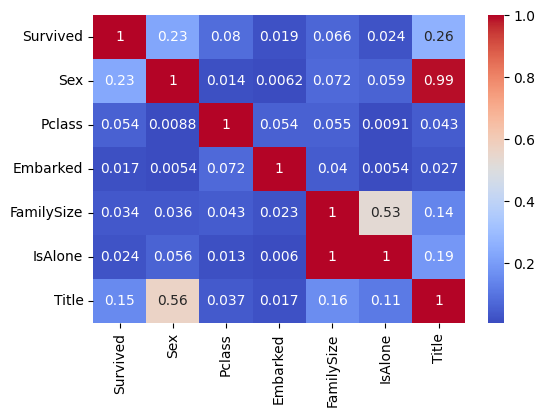

In [108]:
from math import log

def conditional_entropy(x, y):
    y_values = y.value_counts(normalize=True)
    xy = pd.crosstab(x, y, normalize='columns')
    ent = 0
    for c in y_values.index:
        sub = xy[c]
        ent += y_values[c] * (-np.nansum(sub * np.log2(sub + 1e-9)))
    return ent

def theils_u(x, y):
    s_xy = conditional_entropy(x, y)
    x_entropy = -np.nansum(x.value_counts(normalize=True) * 
                           np.log2(x.value_counts(normalize=True) + 1e-9))
    if x_entropy == 0:
        return 1
    return (x_entropy - s_xy) / x_entropy

cat_cols = ['Survived', 'Sex', 'Pclass', 'Embarked', 'FamilySize', 'IsAlone', 'Title']
theils_matrix = pd.DataFrame(np.zeros((len(cat_cols), len(cat_cols))), 
                             index=cat_cols, columns=cat_cols)

for i in cat_cols:
    for j in cat_cols:
        theils_matrix.loc[i, j] = theils_u(train[i], train[j])

plt.figure(figsize=(6,4))
sns.heatmap(theils_matrix, annot=True, cmap='coolwarm')
plt.show()

In [109]:
train.groupby('IsAlone')['Survived'].mean()

IsAlone
0    0.484099
1    0.305361
Name: Survived, dtype: float64

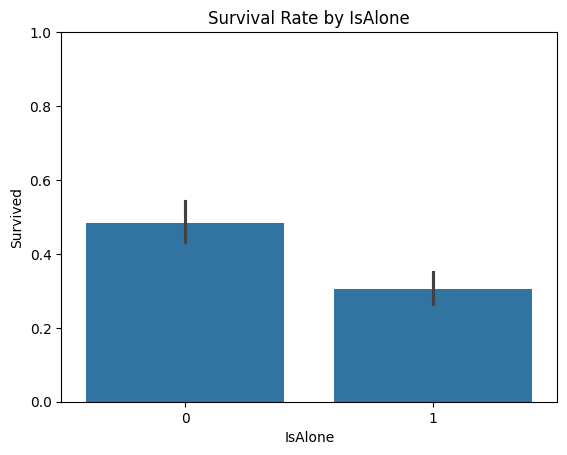

In [110]:
sns.barplot(
    x='IsAlone',
    y='Survived',
    data=train,
    estimator='mean'
)

plt.ylim(0,1)
plt.title('Survival Rate by IsAlone')
plt.show()

In [111]:
train.groupby('FamilySize')['Survived'].mean()

FamilySize
1     0.305361
2     0.519685
3     0.556962
4     0.730769
5     0.181818
6     0.176471
7     0.300000
8     0.000000
11    0.000000
Name: Survived, dtype: float64

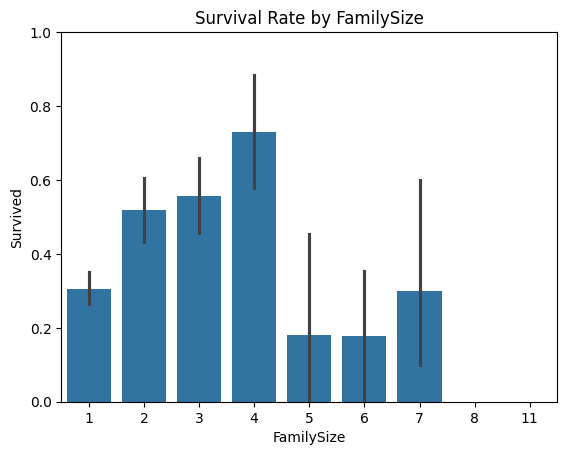

In [112]:
sns.barplot(
    x='FamilySize',
    y='Survived',
    data=train,
    estimator='mean'
)

plt.ylim(0,1)
plt.title('Survival Rate by FamilySize')
plt.show()

In [113]:
train.groupby('Title')['Survived'].mean()

Title
Master    0.545455
Miss      0.671233
Mr        0.155131
Mrs       0.836735
Rare      0.312500
Name: Survived, dtype: float64

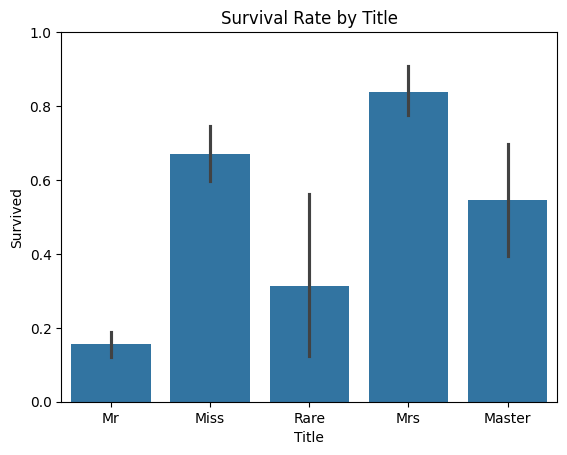

In [114]:
sns.barplot(
    x='Title',
    y='Survived',
    data=train,
    estimator='mean'
)

plt.ylim(0,1)
plt.title('Survival Rate by Title')
plt.show()

# Transformation

In [115]:
train['Fare_log'] = np.log1p(train['Fare'])
test['Fare_log'] = np.log1p(test['Fare'])
unseen['Fare_log'] = np.log1p(unseen['Fare'])

In [116]:
num_cols = ['Survived', 'Age', 'Fare_log', 'FamilySize', 'SibSp', 'Parch']

In [117]:
train[num_cols].skew()

Survived      0.511293
Age           0.373128
Fare_log      0.403554
FamilySize    2.753703
SibSp         3.619385
Parch         2.695459
dtype: float64

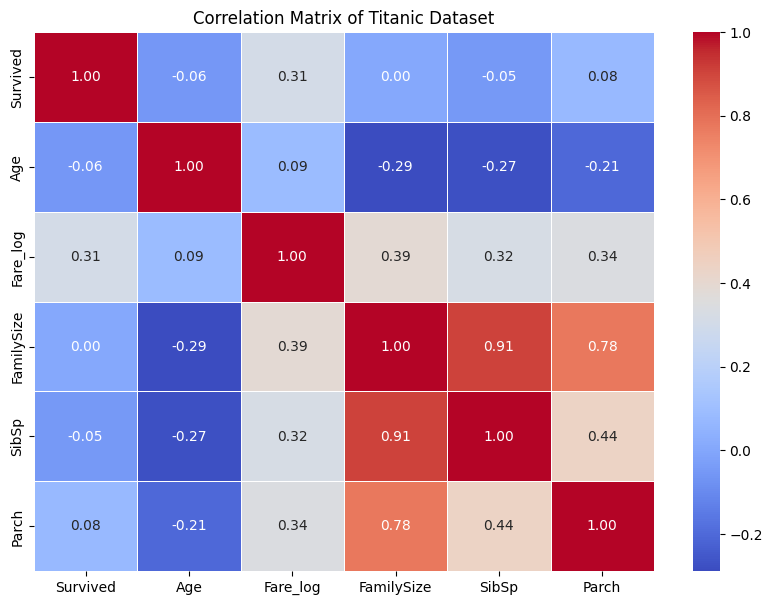

In [118]:
corr = train[num_cols].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Titanic Dataset")
plt.show()

# Scaling

In [119]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize',
       'IsAlone', 'HasCabin', 'Fare_log'],
      dtype='object')

In [120]:
num_cols = ['Age', 'Fare_log', 'FamilySize', 'SibSp', 'Parch']

scaler = StandardScaler()

train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])
unseen[num_cols] = scaler.transform(unseen[num_cols])

In [121]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,HasCabin,Fare_log
count,712.000000,712.000000,712.000000,7.120000e+02,7.120000e+02,7.120000e+02,712.000000,7.120000e+02,712.000000,712.000000,7.120000e+02
mean,448.234551,0.376404,2.330056,-6.112464e-17,1.746418e-17,2.245395e-17,32.586276,-4.989766e-17,0.602528,0.223315,-1.871162e-17
std,256.731423,0.484824,0.824584,1.000703e+00,1.000703e+00,1.000703e+00,51.969529,1.000703e+00,0.489719,0.416760,1.000703e+00
min,1.000000,0.000000,1.000000,-2.192115e+00,-4.707224e-01,-4.793416e-01,0.000000,-5.546661e-01,0.000000,0.000000,-3.015126e+00
25%,224.750000,0.000000,2.000000,-5.546378e-01,-4.707224e-01,-4.793416e-01,7.925000,-5.546661e-01,0.000000,0.000000,-7.822006e-01
50%,453.500000,0.000000,3.000000,5.239728e-02,-4.707224e-01,-4.793416e-01,14.454200,-5.546661e-01,1.000000,0.000000,-2.221223e-01
75%,673.500000,1.000000,3.000000,4.317942e-01,3.799232e-01,-4.793416e-01,30.500000,4.009635e-02,1.000000,0.000000,5.043216e-01
max,891.000000,1.000000,3.000000,3.846367e+00,6.334442e+00,7.104908e+00,512.329200,5.392959e+00,1.000000,1.000000,3.351442e+00


# Encode Categorical Variables

In [122]:
train['Sex'].value_counts()

Sex
male      467
female    245
Name: count, dtype: int64

In [123]:
train['Embarked'].value_counts()

Embarked
S    527
C    125
Q     60
Name: count, dtype: int64

In [124]:
train['Title'].value_counts()

Title
Mr        419
Miss      146
Mrs        98
Master     33
Rare       16
Name: count, dtype: int64

In [125]:
cat_cols = ['Sex', 'Embarked', 'Title', 'Pclass']

In [126]:
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)
unseen = pd.get_dummies(unseen, columns=cat_cols, drop_first=True)

In [127]:
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,...,Fare_log,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Pclass_2,Pclass_3
0,332,0,"Partner, Mr. Austen",1.228528,-0.470722,-0.479342,113043,28.5000,C124,-0.554666,...,0.437404,True,False,True,False,True,False,False,False,False
1,734,0,"Berriman, Mr. William John",-0.478758,-0.470722,-0.479342,28425,13.0000,NaN,-0.554666,...,-0.322935,True,False,True,False,True,False,False,True,False
2,383,0,"Tikkanen, Mr. Juho",0.204156,-0.470722,-0.479342,STON/O 2. 3101293,7.9250,NaN,-0.554666,...,-0.782201,True,False,True,False,True,False,False,False,True
3,705,0,"Hansen, Mr. Henrik Juul",-0.251120,0.379923,-0.479342,350025,7.8542,NaN,0.040096,...,-0.790325,True,False,True,False,True,False,False,False,True
4,814,0,"Andersson, Miss. Ebba Iris Alfrida",-1.768708,2.931860,2.048742,347082,31.2750,NaN,3.013909,...,0.529116,False,False,True,True,False,False,False,False,True


# Feature Selection

In [128]:
train.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'FamilySize', 'IsAlone', 'HasCabin', 'Fare_log',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [129]:
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare', 'SibSp', 'Parch', 'Sex_male']

In [130]:
train = train.drop(columns=cols_to_drop, axis=1, errors='ignore')
test = test.drop(columns=cols_to_drop, axis=1, errors='ignore')
unseen = unseen.drop(columns=cols_to_drop, axis=1, errors='ignore')

In [131]:
train.head()

,Survived,Age,FamilySize,IsAlone,HasCabin,Fare_log,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Pclass_2,Pclass_3
0,0,1.228528,-0.554666,1,1,0.437404,False,True,False,True,False,False,False,False
1,0,-0.478758,-0.554666,1,0,-0.322935,False,True,False,True,False,False,True,False
2,0,0.204156,-0.554666,1,0,-0.782201,False,True,False,True,False,False,False,True
3,0,-0.251120,0.040096,0,0,-0.790325,False,True,False,True,False,False,False,True
4,0,-1.768708,3.013909,0,0,0.529116,False,True,True,False,False,False,False,True


In [132]:
train.to_csv('../data/featured/featured_train.csv', index=False)
test.to_csv('../data/featured/featured_test.csv', index=False)
unseen.to_csv('../data/featured/featured_unseen.csv', index=False)